## Lung Cancer Detection Using Convolution Neural Network (CNN)

#### Dataset were taken from https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images

## Importing Dataset

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


### Data Visualization

In [11]:
#path = "D:\RESUME\ML\Lung cancer\archive\lung_colon_image_set\lung_image_sets"
path=(r'D:\RESUME\ML\Lung cancer\archive\lung_colon_image_set\lung_image_sets')
classes = os.listdir(path)
classes


['lung_aca', 'lung_n', 'lung_scc']

### This dataset includes 5000 images for three classes of lung conditions:

#### Normal Class
#### Lung Adenocarcinomas
#### Lung Squamous Cell Carcinomas


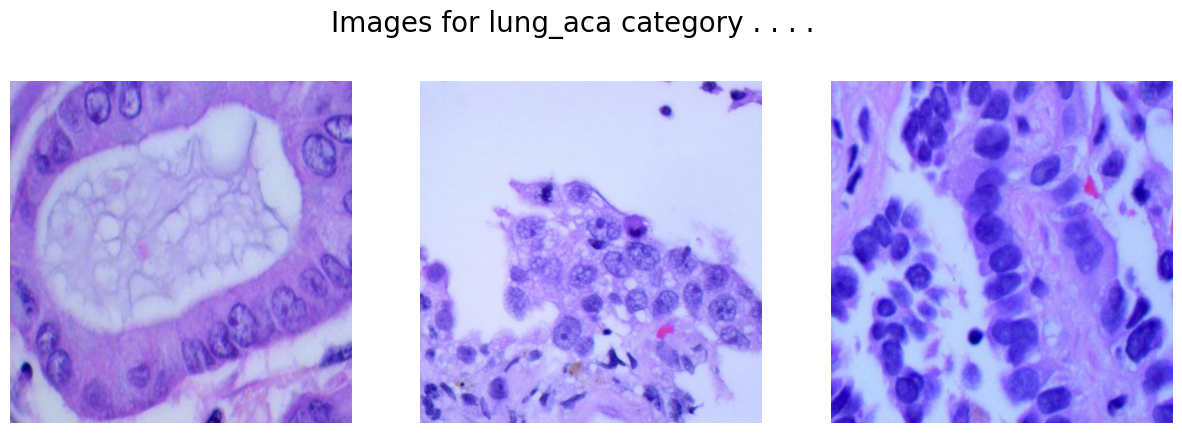

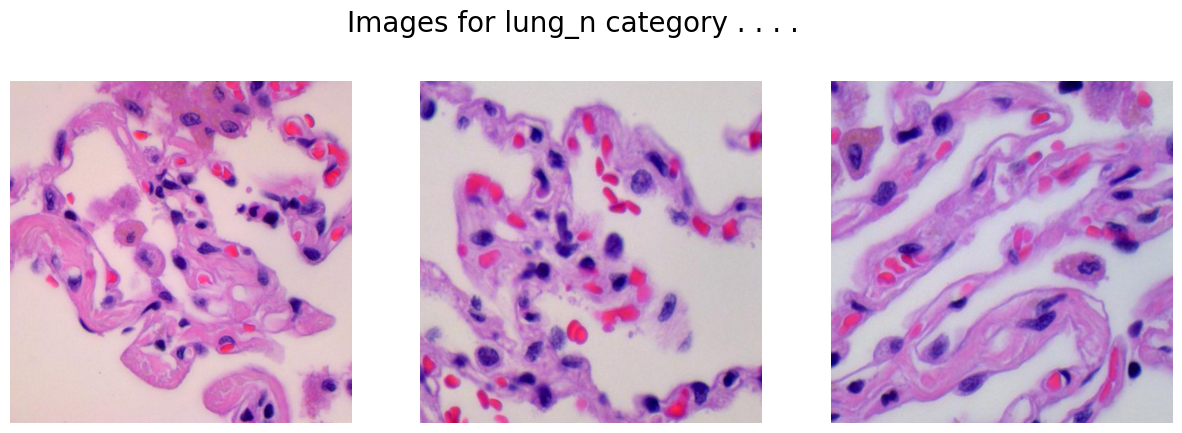

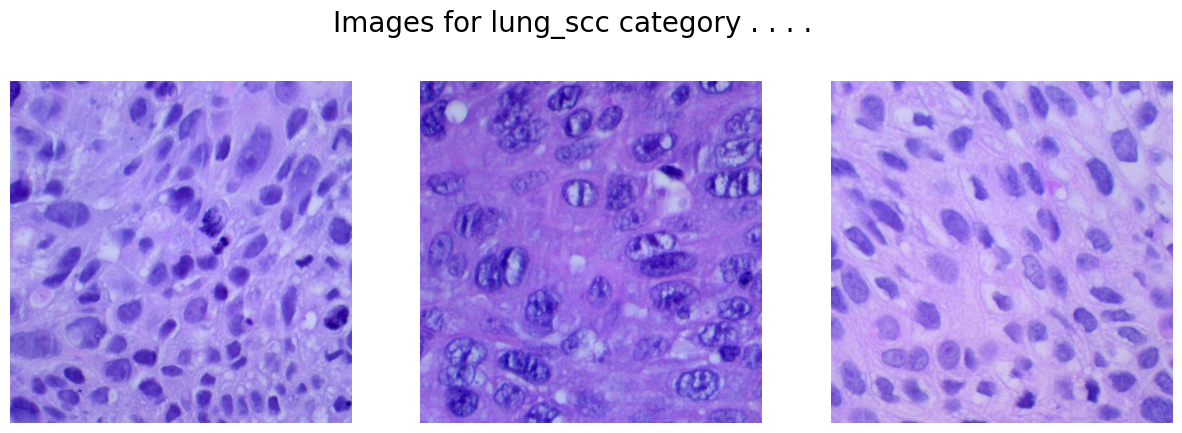

In [12]:
#path = '/lung_colon_image_set/lung_image_sets'
path=(r'D:\RESUME\ML\Lung cancer\archive\lung_colon_image_set\lung_image_sets')
for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


# Data Preparation for Training

### In this section, given images are converted  into NumPy arrays of their pixels after resizing them 

In [15]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [18]:
X = []
Y = []

for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')

    for image in images:
        img = cv2.imread(image)

        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [19]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,test_size = SPLIT,random_state = 2022)
print(X_train.shape, X_val.shape)


(12000, 256, 256, 3) (3000, 256, 256, 3)


### Achieved the shuffling of data automatically because the train_test_split function split the data randomly in the given ratio.

# Model Development

## Model Architecture

In [20]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

### The CNN model contains about 33.5 Million parameters.

In [34]:
keras.utils.plot_model(model,show_shapes = True,show_dtype = True,show_layer_activations = True)


In [26]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)

## Call back

In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_accuracy') > 0.90:
			print('\n Validation accuracy has reached upto \
					90% so, stopping further training.')
			self.model.stop_training = True


es = EarlyStopping(patience=3,monitor='val_accuracy',restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.5,verbose=1)


### Training the model

In [28]:
history = model.fit(X_train, Y_train,validation_data = (X_val, Y_val),batch_size = BATCH_SIZE,epochs = EPOCHS,verbose = 1,callbacks = [es, lr, myCallback()])


Epoch 1/10
188/188 [==============================] - 820s 4s/step - loss: 0.3682 - accuracy: 0.8488 - val_loss: 6.6595 - val_accuracy: 0.4233 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 809s 4s/step - loss: 0.2147 - accuracy: 0.9156 - val_loss: 9.7860 - val_accuracy: 0.6703 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - 805s 4s/step - loss: 0.1696 - accuracy: 0.9331 - val_loss: 2.3459 - val_accuracy: 0.3393 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 804s 4s/step - loss: 0.1582 - accuracy: 0.9395 - val_loss: 5.4911 - val_accuracy: 0.3547 - lr: 0.0010
Epoch 5/10
188/188 [==============================] - 811s 4s/step - loss: 0.1180 - accuracy: 0.9524 - val_loss: 0.3374 - val_accuracy: 0.8917 - lr: 0.0010
Epoch 6/10
188/188 [==============================] - 821s 4s/step - loss: 0.1050 - accuracy: 0.9603 - val_loss: 2.6162 - val_accuracy: 0.6280 - lr: 0.0010
Epoch 7/10
188/188 [==============================] - ETA: 0s - 

### Visualizing the training data

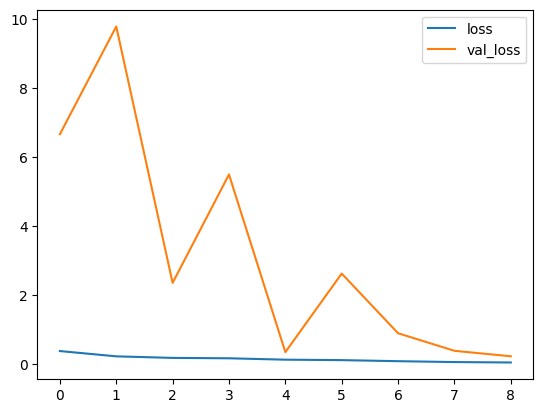

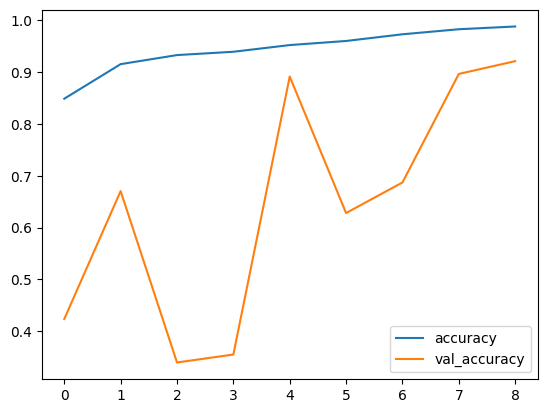

In [29]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

### Model Evaluation

In [30]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 42s 446ms/step


In [31]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[907,   1,  79],
       [ 11, 966,   0],
       [145,   0, 891]], dtype=int64)

In [32]:
print(metrics.classification_report(Y_val, Y_pred,target_names=classes))


              precision    recall  f1-score   support

    lung_aca       0.85      0.92      0.88       987
      lung_n       1.00      0.99      0.99       977
    lung_scc       0.92      0.86      0.89      1036

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



### The performance of CNN model is very good as the f1-score for each class is above 0.90 which means model’s prediction is correct 90% of the time. 